In [1]:
"*ein: http://127.0.0.1:8899/make_figs.ipynb*"
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*<2>"))

SyntaxError: invalid syntax (<ipython-input-1-7bcf22491de6>, line 2)

In [2]:
%pylab inline
import os,sys
import pickle
from importlib import reload
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
import matplotlib as mpl
print(f"Using matplotlib version {mpl.__version__}.")
from matplotlib.gridspec import GridSpec
from scipy.signal import stft
from builtins import sum as bsum

Populating the interactive namespace from numpy and matplotlib
Using matplotlib version 3.6.1.


In [3]:
PLOT = True # Whether to actually make the plots

In [5]:
from copy import deepcopy

In [4]:
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
FisherPlumes = fp.FisherPlumes

force_reload = False
if force_reload or ('Fbw' not in locals()):
    pairs_mode = "unsigned"
    Fbw = FisherPlumes("boulder16", pitch_in_um = 7500,  freq_max = 20,  which_coords = [(0.45, 0.5)], py_mode = "relative", suffix = 'wideDomain.old',pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
    Fcr = FisherPlumes("n12dishT",  pitch_in_um = 76000, freq_max = 100, which_coords = [(1.0, 0.5)], pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
else:
    Fbw = FisherPlumes(Fbw)
    Fcr = FisherPlumes(Fcr)
    
data = {
    "cr":Fcr,
    "bw":Fbw
}

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


           fisher_plumes 2022/10/28 14:44:50     INFO: ****** LOADING sim_name='boulder16' ******


     fisher_plumes_tools 2022/10/28 14:44:50     INFO: Using relative py coordinates.


INFO:boulder:Loading data from file_name='Re100_0_5mm_50Hz_16source_wideDomain.old.h5'.


INFO:boulder:
Re100_0_5mm_50Hz_16source_wideDomain.old.h5 <BoulderSimulationData>
x_lim: [0.0, 0.5]
y_lim: [-0.21125, 0.21125]
x-y Dimensions: [0.5    0.4225]
x-range: 0.000, 0.001 ... 0.500 (1001 points)
y-range: 0.211, 0.211 ... -0.211 (846 points)
t-range: 0.000, 0.020 ... 60.000 (3001 points)
fs: 50 Hz
Sources:
  0: =    c1a @ (x = +0, y = +0.00375)
  1: =    c1b @ (x = +0, y = -0.00375)
  2: =    c2a @ (x = +0, y = +0.01125)
  3: =    c2b @ (x = +0, y = -0.01125)
  4: =    c3a @ (x = +0, y = +0.01875)
  5: =    c3b @ (x = +0, y = -0.01875)
  6: =    c4a @ (x = +0, y = +0.02625)
  7: =    c4b @ (x = +0, y = -0.02625)
  8: =    c5a @ (x = +0, y = +0.03375)
  9: =    c5b @ (x = +0, y = -0.03375)
 10: =    c6a @ (x = +0, y = +0.04125)
 11: =    c6b @ (x = +0, y = -0.04125)
 12: =    c7a @ (x = +0, y = +0.04875)
 13: =    c7b @ (x = +0, y = -0.04875)
 14: =    c8a @ (x = +0, y = +0.05625)
 15: =    c8b @ (x = +0, y = -0.05625)


INFO:boulder:Mapped coordinate ( 0.450,  0.000) to ( 0.450,  0.000), index (900, 422), name 'x=45 cm'.


INFO:boulder:Field c1a has shape (3001, 1).


INFO:boulder:Field c1b has shape (3001, 1).


INFO:boulder:Field c2a has shape (3001, 1).


INFO:boulder:Field c2b has shape (3001, 1).


INFO:boulder:Field c3a has shape (3001, 1).


INFO:boulder:Field c3b has shape (3001, 1).


INFO:boulder:Field c4a has shape (3001, 1).


INFO:boulder:Field c4b has shape (3001, 1).


INFO:boulder:Field c5a has shape (3001, 1).


INFO:boulder:Field c5b has shape (3001, 1).


INFO:boulder:Field c6a has shape (3001, 1).


INFO:boulder:Field c6b has shape (3001, 1).


INFO:boulder:Field c7a has shape (3001, 1).


INFO:boulder:Field c7b has shape (3001, 1).


INFO:boulder:Field c8a has shape (3001, 1).


INFO:boulder:Field c8b has shape (3001, 1).


     fisher_plumes_tools 2022/10/28 14:45:41     INFO: Computing pairs for len(yvals)=16 from -112500 to 112500 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/28 14:45:41     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2022/10/28 14:45:41     INFO: ****** LOADING sim_name='n12dishT' ******


INFO:crick:load_sims for sim_name='n12dishT' with which_coords=[(1.0, 0.5)] (py_mode='absolute').


     fisher_plumes_tools 2022/10/28 14:45:41     INFO: Using absolute py coordinates.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.480


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.550


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.450


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.490


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=1 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.495


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.505


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.510


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-1 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.500


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.520


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.498


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.502


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.2 cm.


INFO:crick:Yvals: [450000, 480000, 490000, 495000, 498000, 500000, 502000, 505000, 510000, 520000, 550000]


INFO:crick:Computing distance pairings.


     fisher_plumes_tools 2022/10/28 14:45:52     INFO: Computing pairs for len(yvals)=11 from 450000 to 550000 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/28 14:45:52     INFO: Removing duplicates in pairs dictionary.


INFO:crick:24 distance pairings found, from 0 to 100000


# Compute all the statistics

In [6]:
wnd_sec_vals = [1,2]
dmax    = {"bw":np.inf, "cr":np.inf}
data_wnd = {}
for wnd_sec in wnd_sec_vals:
    wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
    istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
    [(print(k, end = ""), sys.stdout.flush(), F.compute_all_for_window(wnd = wnd[k],
                                                                       istart = istart[k],
                                                                       window = 'boxcar',
                                                                       tukey_param = 0,
                                                                       dmax = dmax[k],
                                                                       fit_vars = False,                                                                  
    )) for k, F in data.items() if k != "acr"];
    data_wnd[wnd_sec] = deepcopy(data)

cr

           fisher_plumes 2022/10/28 14:47:58     INFO: Window set to self.wnd=1000.


           fisher_plumes 2022/10/28 14:47:58     INFO: Computing trig coefficients for n12dishT with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/28 14:48:00     INFO: Computing variances for harmonics.


           fisher_plumes 2022/10/28 14:48:01     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/28 14:48:12     INFO: Computing lambdas.


           fisher_plumes 2022/10/28 14:48:12     INFO: Creating pooling functions.


           fisher_plumes 2022/10/28 14:48:52     INFO: Computing p-values.


           fisher_plumes 2022/10/28 14:48:52     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:49:11     INFO: Computing R^2-values.


           fisher_plumes 2022/10/28 14:49:11     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:49:14     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/28 14:49:14     INFO: Using 24 distances <= inf


           fisher_plumes 2022/10/28 14:49:14     INFO: Computed λ for 501 frequencies and 24 distances and 51 bootstraps.


           fisher_plumes 2022/10/28 14:49:14     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/28 14:49:53    DEBUG: self.fit_params.shape=(51, 501, 3).


           fisher_plumes 2022/10/28 14:49:53     INFO: Computing Fisher information (v2).


           fisher_plumes 2022/10/28 14:49:53     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 3000, 4000, 5000, 7000, 8000, 10000, 12000, 15000, 18000, 20000, 22000, 25000, 30000, 40000, 45000, 48000, 50000, 52000, 55000, 60000, 70000, 100000].


           fisher_plumes 2022/10/28 14:49:53     INFO: Done computing all for wnd=1000.


bw

           fisher_plumes 2022/10/28 14:49:53     INFO: Window set to self.wnd=50.


           fisher_plumes 2022/10/28 14:49:53     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/28 14:49:53     INFO: Computing variances for harmonics.


           fisher_plumes 2022/10/28 14:49:53     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/28 14:49:54     INFO: Computing lambdas.


           fisher_plumes 2022/10/28 14:49:54     INFO: Creating pooling functions.


           fisher_plumes 2022/10/28 14:49:56     INFO: Computing p-values.


           fisher_plumes 2022/10/28 14:49:56     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:49:57     INFO: Computing R^2-values.


           fisher_plumes 2022/10/28 14:49:57     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:49:57     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/28 14:49:57     INFO: Using 16 distances <= inf


           fisher_plumes 2022/10/28 14:49:57     INFO: Computed λ for 26 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2022/10/28 14:49:57     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/28 14:49:59    DEBUG: self.fit_params.shape=(51, 26, 3).


           fisher_plumes 2022/10/28 14:49:59     INFO: Computing Fisher information (v2).


           fisher_plumes 2022/10/28 14:49:59     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 15000, 30000, 45000, 60000, 75000, 90000, 105000, 120000, 135000, 150000, 165000, 180000, 195000, 210000, 225000].


           fisher_plumes 2022/10/28 14:49:59     INFO: Done computing all for wnd=50.


cr

           fisher_plumes 2022/10/28 14:50:03     INFO: Window set to self.wnd=2000.


           fisher_plumes 2022/10/28 14:50:03     INFO: Computing trig coefficients for n12dishT with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/28 14:50:05     INFO: Computing variances for harmonics.


           fisher_plumes 2022/10/28 14:50:06     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/28 14:50:17     INFO: Computing lambdas.


           fisher_plumes 2022/10/28 14:50:17     INFO: Creating pooling functions.


           fisher_plumes 2022/10/28 14:51:13     INFO: Computing p-values.


           fisher_plumes 2022/10/28 14:51:13     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:51:35     INFO: Computing R^2-values.


           fisher_plumes 2022/10/28 14:51:35     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:51:38     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/28 14:51:38     INFO: Using 24 distances <= inf


           fisher_plumes 2022/10/28 14:51:38     INFO: Computed λ for 1001 frequencies and 24 distances and 51 bootstraps.


           fisher_plumes 2022/10/28 14:51:38     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/28 14:52:46    DEBUG: self.fit_params.shape=(51, 1001, 3).


           fisher_plumes 2022/10/28 14:52:46     INFO: Computing Fisher information (v2).


           fisher_plumes 2022/10/28 14:52:46     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 3000, 4000, 5000, 7000, 8000, 10000, 12000, 15000, 18000, 20000, 22000, 25000, 30000, 40000, 45000, 48000, 50000, 52000, 55000, 60000, 70000, 100000].


           fisher_plumes 2022/10/28 14:52:46     INFO: Done computing all for wnd=2000.


bw

           fisher_plumes 2022/10/28 14:52:46     INFO: Window set to self.wnd=100.


           fisher_plumes 2022/10/28 14:52:46     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/28 14:52:46     INFO: Computing variances for harmonics.


           fisher_plumes 2022/10/28 14:52:46     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/28 14:52:47     INFO: Computing lambdas.


           fisher_plumes 2022/10/28 14:52:47     INFO: Creating pooling functions.


           fisher_plumes 2022/10/28 14:52:49     INFO: Computing p-values.


           fisher_plumes 2022/10/28 14:52:49     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:52:50     INFO: Computing R^2-values.


           fisher_plumes 2022/10/28 14:52:50     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2022/10/28 14:52:50     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/28 14:52:50     INFO: Using 16 distances <= inf


           fisher_plumes 2022/10/28 14:52:50     INFO: Computed λ for 51 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2022/10/28 14:52:50     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/28 14:52:55    DEBUG: self.fit_params.shape=(51, 51, 3).


           fisher_plumes 2022/10/28 14:52:55     INFO: Computing Fisher information (v2).


           fisher_plumes 2022/10/28 14:52:55     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 15000, 30000, 45000, 60000, 75000, 90000, 105000, 120000, 135000, 150000, 165000, 180000, 195000, 210000, 225000].


           fisher_plumes 2022/10/28 14:52:55     INFO: Done computing all for wnd=100.


In [43]:
wnd_sec = 1
data = deepcopy(data_wnd[wnd_sec])
fig_dir_fun = lambda wnd_sec: f"figs/wnd_{wnd_sec:g}sec"
fig_dir = fig_dir_fun(wnd_sec)
print(f"Creating {fig_dir=}")
os.mkdir(fig_dir)

Creating fig_dir='figs/wnd_1sec'


FileExistsError: [Errno 17] File exists: 'figs/wnd_1sec'

# Figure showing an example plume and correlations

In [9]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

INFO:boulder:Loading fld='c1a' at t=40 from full_file='./data/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='./data/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='./data/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='./data/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='./data/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='./data/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='./data/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='./data/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='./data/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='./data/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='./data/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='./data/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='./data/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='./data/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='./data/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='./data/c8b_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y480_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y550_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y450_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y490_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y495_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y505_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y510_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y500_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y520_S1_t40.p'.


Wrote figs/wnd_1sec/plumes_demo_bw.pdf.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y498_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y502_S1_t40.p'.


Wrote figs/wnd_1sec/plumes_demo_cr.pdf.


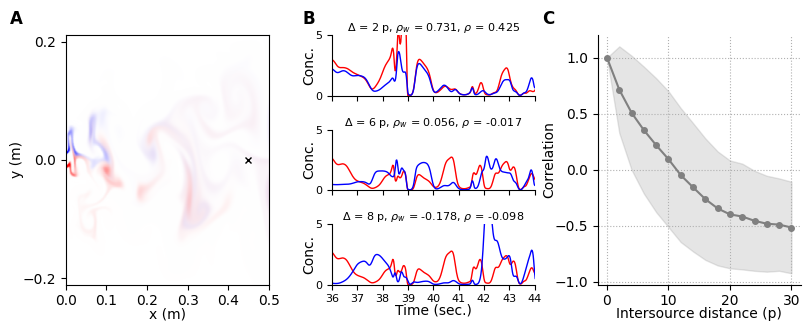

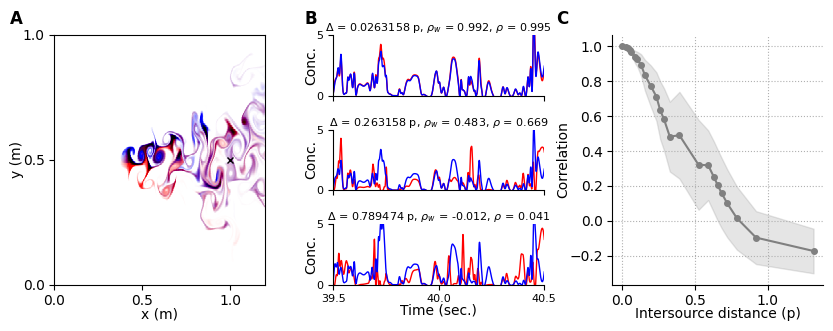

In [10]:
reload(fpf)
reload(fpft)

which_srcs   = {"bw":[-7500, 7500],        "cr":[490000,510000]}
t_wnd        = {"bw":[-4,4],               "cr":[-0.5, 0.5]}
which_idists = {"bw":[0,2,3],              "cr":[0,10,20]}
tticks       = {"bw":DEFAULT,              "cr":[39.5,40,40.5]}
xticks       = {"bw":DEFAULT,              "cr":np.arange(0,1.1,0.5)}
yticks       = {"bw":[-0.2,0,0.2],         "cr":[0,0.5,1]}

for k, F in sorted(data.items()):
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, 40, which_srcs[k], y_lim = (0,5.01), t_wnd = t_wnd[k], dt = 1, which_idists=which_idists[k])
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])

    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir}/plumes_demo_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));    

# Figure showing the distribution of correlations

cr
Mapped frequencies [1, 3, 7, 10] to indices [1, 3, 7, 10].


Wrote figs/wnd_1sec/corr_components_cr.pdf.
bw
Mapped frequencies [1, 3, 7, 10] to indices [1, 3, 7, 10].


Wrote figs/wnd_1sec/corr_components_bw.pdf.


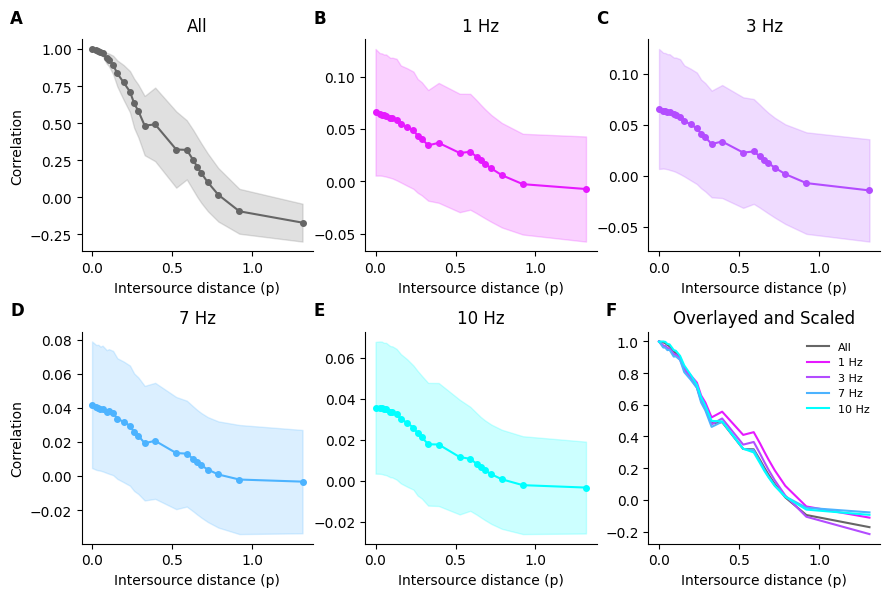

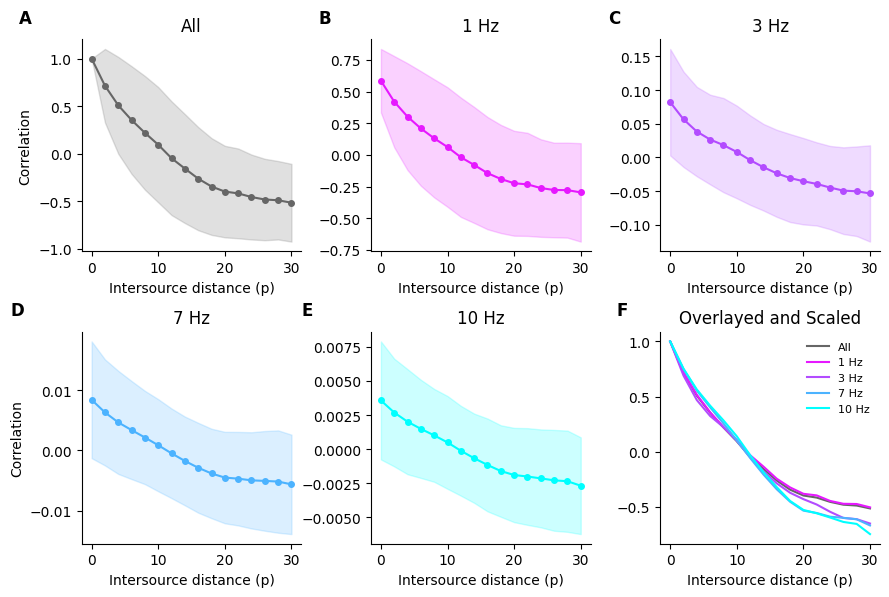

In [11]:
reload(fpf)
which_freqs = [1,3,7,10]
labs = [f"{f} Hz" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f/10) for f in which_freqs])})
xlims_  = {"bw":DEFAULT, "cr":DEFAULT}
xticks_ = {"bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho, F.pitch_in_um, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel("Intersource distance (p)"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)        
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

bw
Mapped 5 Hz to index 5.


Wrote figs/wnd_1sec/coef_vs_coef_bw_5Hz.pdf.
cr
Mapped 5 Hz to index 5.


Wrote figs/wnd_1sec/coef_vs_coef_cr_5Hz.pdf.


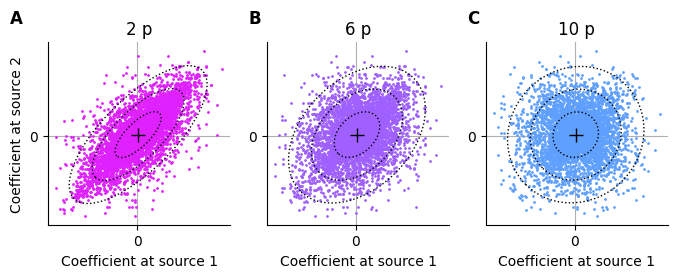

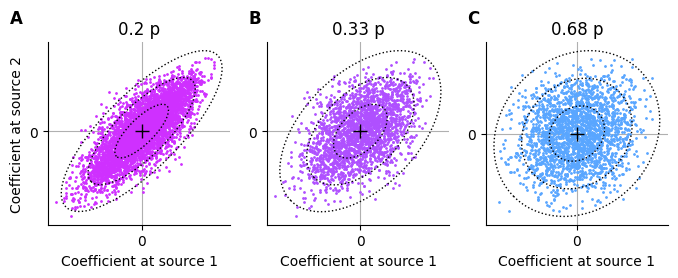

In [12]:
reload(fpf)
which_freqs = {"bw":5,       "cr":5}
which_idists= {"bw":[0,2,4], "cr":[8,12,18]}
dcol_scales = {"bw":120000,  "cr":80000}
for name, F in sorted(data.items()):
    print(name)
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    print(f"Mapped {which_freq} Hz to index {ifreq}.")
    ax = fpf.plot_coef1_vs_coef2([F.ss, F.cc],
                                 ifreq,
                                 F.pairs,
                                 F.pitch_in_um,                                 
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir}/coef_vs_coef_{name}_{which_freq}Hz.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Supplementary Information

Wrote figs/wnd_1sec/coefs_and_traces_bw_5Hz.pdf.


Wrote figs/wnd_1sec/coefs_and_traces_cr_5Hz.pdf.


<Figure size 800x300 with 0 Axes>

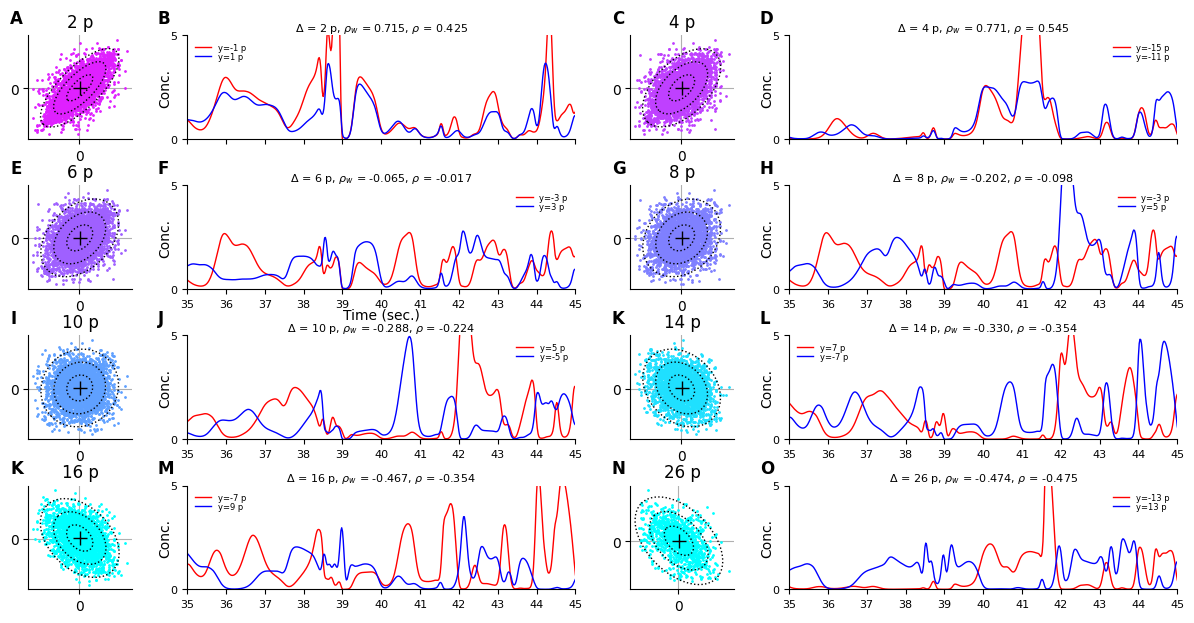

<Figure size 800x300 with 0 Axes>

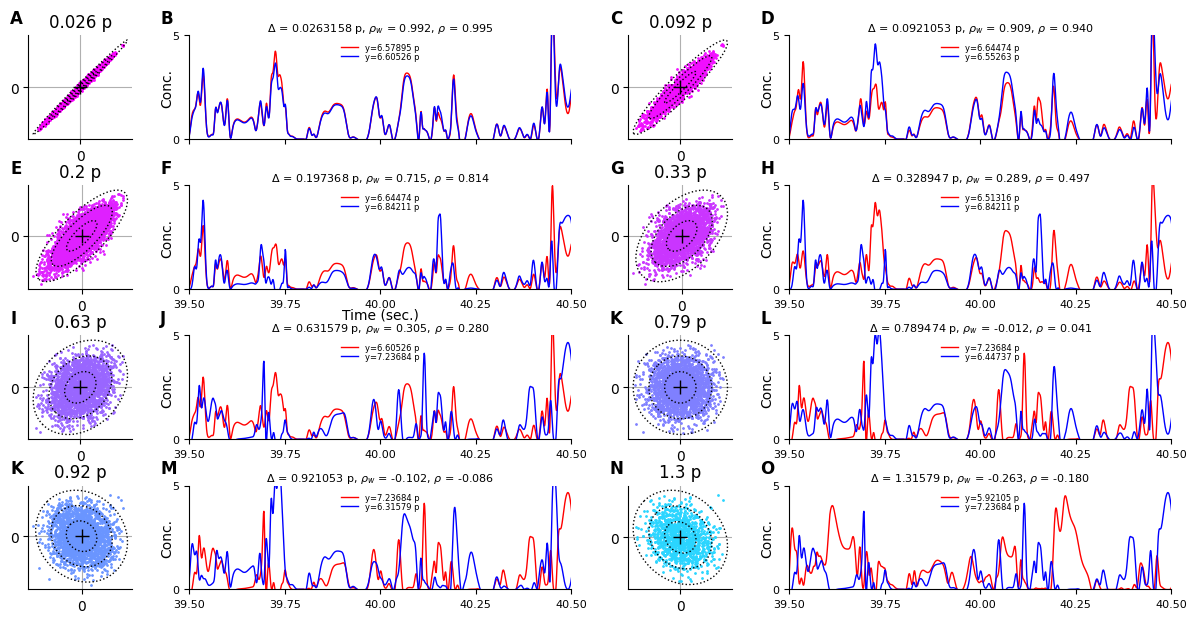

In [13]:
reload(fpf)
reload(fpft)
freq      = {"bw":5, "cr":5}
idists    = {"bw":[0,1,2,3,4,6,7,12], "cr":[0,4,8,12,16,20,21,22]}
t_lim     = {"bw":[35, 45],       "cr":[39.5,40.5]}
dt        = {"bw":1,              "cr":0.25}
for k, F in sorted(data.items()):
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k], n_per_row = 2, y_lim=[0,5], t_lim = t_lim[k], dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    "ABCDEFGHIJKLKMNOPQRSTUVWXYZ",
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir}/coefs_and_traces_{k}_{freq[k]}Hz.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

In [27]:
Fbw.pvals[0]

array([[5.99393819e-39, 2.63817992e-30, 1.80686081e-05, ...,
        1.81550824e-58, 1.41076601e-59, 3.43391309e-58],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

# Asymmetric Laplacian Fits

In [ ]:
reload(fpft)
reload(fpf)
which_wnd_sec = 1
idist     = {"bw":[1,2,3],       "cr":[1,13,19]}
freq_max  = {"bw":21,            "cr":101}
vmin      = {"bw":[0,0.8],       "cr":[0,0.8]}
vmax      = {"bw":[50,1],        "cr":[10,1]}
for name, F in sorted(data_wnd[which_wnd_sec].items()):
    d = np.array(list(F.rho.keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10]:
        which_freq = {"bw":f, "cr":f}
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir_fun(which_wnd_sec)}/alap_fits_{name}_{which_freq[name]}Hz.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

d=15000 @ Freq #   1: -np.log10(p) = 154.903
d=30000 @ Freq #   1: -np.log10(p) = 109.318
d=45000 @ Freq #   1: -np.log10(p) = 86.589
Setting extent to [-0.5, 15.5, 0.5, 20.5].
Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/wnd_1sec/alap_fits_bw_1Hz.pdf.
d=15000 @ Freq #   5: -np.log10(p) = 3.550
d=30000 @ Freq #   5: -np.log10(p) = 5.478
d=45000 @ Freq #   5: -np.log10(p) = 6.263
Setting extent to [-0.5, 15.5, 0.5, 20.5].
Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/wnd_1sec/alap_fits_bw_5Hz.pdf.
d=15000 @ Freq #  10: -np.log10(p) = 31.977
d=30000 @ Freq #  10: -np.log10(p) = 18.155
d=45000 @ Freq #  10: -np.log10(p) = 9.682
Setting extent to [-0.5, 15.5, 0.5, 20.5].
Setting extent to [-0.5, 15.5, 0.5, 20.5].


Wrote figs/wnd_1sec/alap_fits_bw_10Hz.pdf.
d=2000 @ Freq #   1: -np.log10(p) = 1.847
d=25000 @ Freq #   1: -np.log10(p) = 0.519
d=52000 @ Freq #   1: -np.log10(p) = 0.429


Setting extent to [-0.5, 23.5, 0.5, 100.5].
Setting extent to [-0.5, 23.5, 0.5, 100.5].


Wrote figs/wnd_1sec/alap_fits_cr_1Hz.pdf.
d=2000 @ Freq #   5: -np.log10(p) = 2.532
d=25000 @ Freq #   5: -np.log10(p) = 1.676
d=52000 @ Freq #   5: -np.log10(p) = 0.815
Setting extent to [-0.5, 23.5, 0.5, 100.5].
Setting extent to [-0.5, 23.5, 0.5, 100.5].


# Plot the figure showing λ(s)

      fisher_plumes_figs 2022/10/27 11:19:28     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 6, 14, 20], log_scale=True.


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:390: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_xticklabels(f"{10**xti:.2g}" for xti in xt)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_yticklabels(f"{10**yti:.2g}" for yti in yt)


      fisher_plumes_figs 2022/10/27 11:19:29     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[2, 6, 14, 20], log_scale=True.


Wrote figs/wnd_2sec/la_vs_s_fits_bw.pdf.


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:390: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_xticklabels(f"{10**xti:.2g}" for xti in xt)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_yticklabels(f"{10**yti:.2g}" for yti in yt)


Wrote figs/wnd_2sec/la_vs_s_fits_cr.pdf.


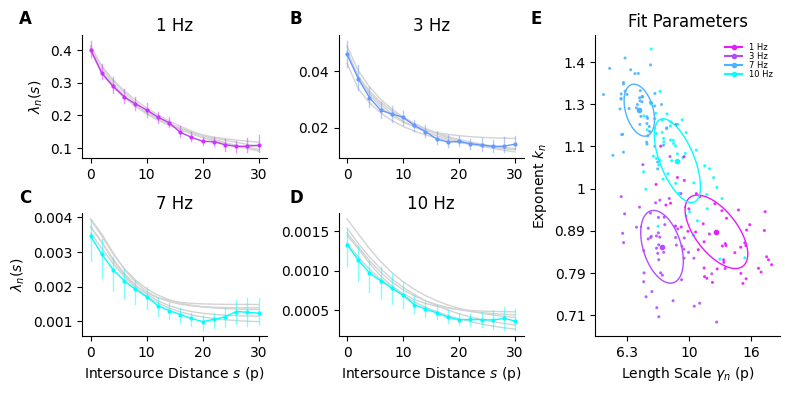

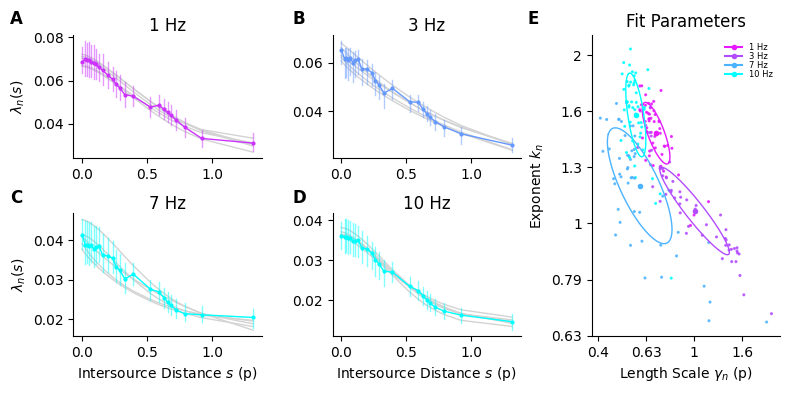

In [49]:
reload(fpft)
reload(fpf)
xl     = {"bw":(-10,200),   "cr": (-2, 50)}
freqs  = {"bw":[1,3,7,10],  "cr": [1,3,7,10]}
xt     = {"bw":arange(0,201,50), "cr":arange(0,101,25)}
xtp    = {"bw":np.array([60,90,135]), "cr":np.array([40,60, 90, 135])}
ytp    = {"bw":np.array([0.8,1,1.2,1.5]), "cr":np.array([0.8,1,1.2,1.5,2])}
for k, F in sorted(data.items()):
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          #xt = log10(xtp[k]), yt = log10(ytp[k]),
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel("Intersource Distance $s$ (p)")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir}/la_vs_s_fits_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Fisher Information

      fisher_plumes_figs 2022/10/27 11:19:31     INFO: dd[0]=100, dd[-1]=225000


      fisher_plumes_figs 2022/10/27 11:19:31     INFO: Plotting which_ifreqs=[1, 10, 6].


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:499: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fisher.set_xticklabels(ax_fisher.get_xticklabels(), fontsize=8)
      fisher_plumes_figs 2022/10/27 11:19:31     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 6, 10], log_scale=True.


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:390: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_xticklabels(f"{10**xti:.2g}" for xti in xt)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_yticklabels(f"{10**yti:.2g}" for yti in yt)


      fisher_plumes_figs 2022/10/27 11:19:31     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 6, 10], log_scale=True.


      fisher_plumes_figs 2022/10/27 11:19:31     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 6, 10], log_scale=True.


      fisher_plumes_figs 2022/10/27 11:19:32     INFO: dd[0]=100, dd[-1]=100000


Wrote figs/wnd_2sec/fisher_info_bw.pdf.


      fisher_plumes_figs 2022/10/27 11:19:33     INFO: Plotting which_ifreqs=[1, 66, 102, 103, 27, 44, 147, 87, 185, 154, 187, 60].


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:499: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fisher.set_xticklabels(ax_fisher.get_xticklabels(), fontsize=8)
      fisher_plumes_figs 2022/10/27 11:19:33     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 27, 44, 60, 66, 87, 102, 103, 147, 154, 185, 187], log_scale=True.


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:390: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_xticklabels(f"{10**xti:.2g}" for xti in xt)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_yticklabels(f"{10**yti:.2g}" for yti in yt)
      fisher_plumes_figs 2022/10/27 11:19:33     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 27, 44, 60, 66, 87, 102, 103, 147, 154, 185, 187], log_scale=True.


      fisher_plumes_figs 2022/10/27 11:19:33     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 27, 44, 60, 66, 87, 102, 103, 147, 154, 185, 187], log_scale=True.


Wrote figs/wnd_2sec/fisher_info_cr.pdf.


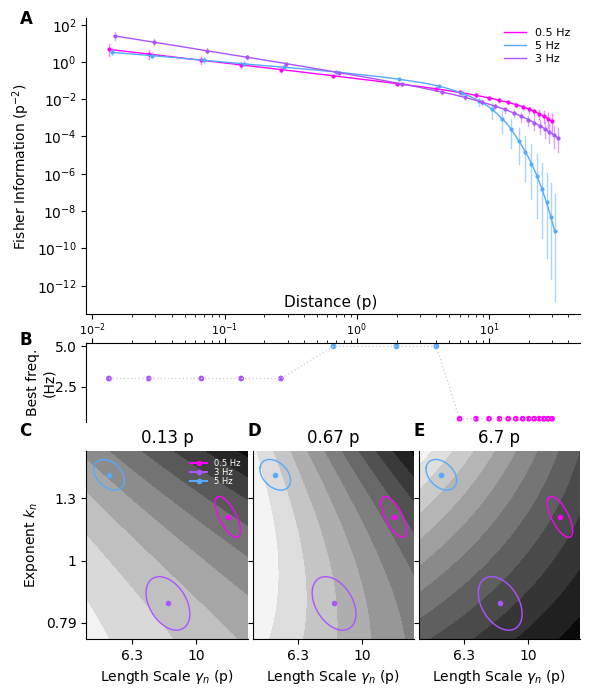

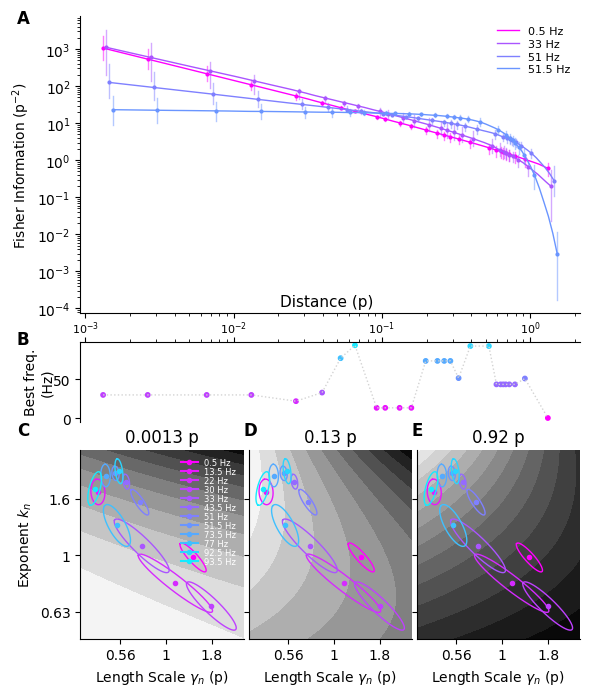

In [50]:
reload(fpft)
reload(fpf)
freqs["bw"] = [1, 3, 7, 10]
freqs["cr"] = [10,20,30,40]
freq_max={"bw":20, "cr":100}
colscale = {"bw":10, "cr":40}
d_vals = {"bw":[1,5,50], "cr":[0.1,10,70]}
d_lim = {"bw":[100, 200000], "cr":[100, 100000]}
bf_ytick = {"bw":arange(0,13,4), "cr":None}
for k, F in sorted(data.items()):
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,                           
                                                                d_lim   = d_lim[k],
                                                                d_range = list(range(100,1000,100)) + list(range(1000,10000,1000))+list(range(10000,60000,10000)),
                                                                d_vals  = np.array(d_vals[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.05**i),
                                                                fi_scale  = 1, plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                #xt = log10(xtp[k]), yt = log10(ytp[k])
    )
    tight_layout(h_pad=0,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    align_y = [[2,3,4]],
                    align_x = [[0,1,2]],
                    fontsize=12, fontweight="bold", dy=-0.01)                            
    file_name = f"{fig_dir}/fisher_info_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Power in each Signal

Wrote figs/wnd_2sec/spectra.pdf.


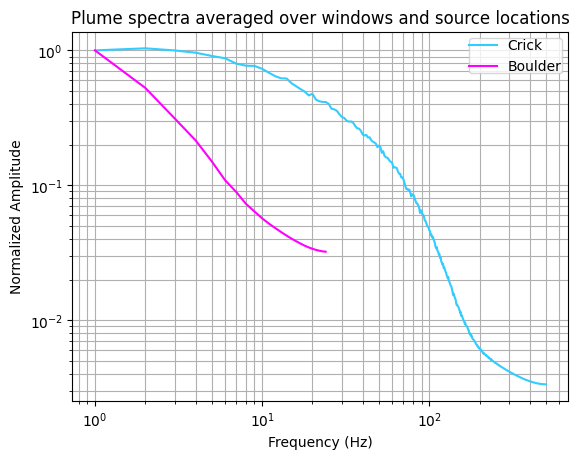

In [51]:
from numpy import fft
from scipy.signal import stft

for k, F in data.items():
    f = []
    for _, s in F.sims.items():
        fr, ti, S = stft(s.data[:,0], fs = F.fs, window='boxcar',
                         nperseg=F.fs, noverlap=F.fs//2, boundary=None, padded=False)
        f.append(np.abs(S))
        
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<F.fs/2][1:],a[fr<F.fs/2][1:]/a[1], label="Crick" if k=="cr" else "Boulder", color={"bw":cm.cool_r(0.0), "cr":cm.cool_r(0.8)}[k])
legend(borderpad=0)
xlabel("Frequency (Hz)")
ylabel("Normalized Amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both')
file_name = f"{fig_dir}/spectra.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));